# Using Non-Negative Matrix Factorization for feature detection, dimension reduction, and classifying

There exist many matrix decomposition methods for tackling machine learning problems, the most famous proabbly being PCA (SVD). Non-negative matrix factorization (NMF) is used in many ways most notably for feature extraction. 

The goal is establish the following decomposition, $$X \approx WH$$ where 
1. $X\in\mathbb{R}^{n\times m}$ where each column is a data point (sample),
2. $W\in\mathbb{R}^{n\times r}$ where each column is a basis element,
3. $H\in\mathbb{R}^{r\times m}$ were each entry is a weight.
4. $W, H \geq 0$.

Point (4) simply says that the entries of $W$ and $H$ are non-negative.

* This method (NMF) __assumes non negative entries of the data matrix $X$__ leading to a *parts-based* representation in contrast to PCA for example.
---
Advantages to NMF:
1. __Easily interpretable__ features of object identified: E.g., noses, cheeks, eyes for faces. Semantic analysis leads to identifying topics in texts.
2. 

Disadvantage to NMF:
1. __Assumes nonnegativity__.
2. Not always clear how to choose $r$, the number of features/topics/classes.

---

There are a number of examples that follow. They are outlined here:


## Facial Feature Extraction

The first example uses the [CBCL face database](http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz) MIT Center For Biological and Computation Learning (2429 gray-level 19-by-19 pixels images).

The goal here is to extract basis elements for a human face for facial recognition applications. Below the data extraction and application is applied with plots supplied that mimic the plots seen in the orignial [Nature paper](https://www.nature.com/articles/44565). 

This is a good use case becasue grayscale is a measure of light intensity in the set $\{0,255\}$ and so it satisfies non-nagitivity. 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from sklearn.decomposition import NMF

%matplotlib inline

In [2]:
class facial_feature_extraction():
    """
    This class applies non-negative matrix factorization to the CBCL face database 
    MIT Center For Biological and Computation Learning (2429 gray-level 19-by-19 
    pixels images) (http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz) 
    using r = 49 as outlined in http://www.ams.org/publicoutreach/feature-column/fc-2019-03
    """
    def __init__(self):
        self.n_components = None
        
    def get_file_list(self, mypath):
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        return onlyfiles

    def make_X_matrix(self, face_filenames):
        image_df = pd.DataFrame()
        for name in face_filenames:
            if not re.search('pgm',name):
                continue
            try:
                image = self.read_pgm(faces_path + name, byteorder='<')

                image_df[name] = image.flatten()
            except ValueError:
                continue

        return image_df
    
    def read_pgm(self, filename, byteorder='>'):
        """Return image data from a raw PGM file as numpy array.

        Format specification: http://netpbm.sourceforge.net/doc/pgm.html

        """
        with open(filename, 'rb') as f:
            buffer = f.read()
        try:
            header, width, height, maxval = re.search(
                b"(^P5\s(?:\s*#.*[\r\n])*"
                b"(\d+)\s(?:\s*#.*[\r\n])*"
                b"(\d+)\s(?:\s*#.*[\r\n])*"
                b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
        except AttributeError:
            raise ValueError("Not a raw PGM file: '%s'" % filename)
        
        return np.frombuffer(buffer,
                             dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                             count=int(width)*int(height),
                             offset=len(header)
                             ).reshape((int(height), int(width)))
    
    def get_NMF_model(self, X, n_basis_elements=49):
        # X = WH
        self.n_components = n_basis_elements
        self.model = NMF(n_components=self.n_components, 
                         init='random',
                         random_state=5,
                         solver='mu',
                         max_iter=1000) # n_components is r in literature
        self.W = self.model.fit_transform(X)
        self.H = self.model.components_
        
        return self
    
    def get_and_plot_image(self, image_data, j = 10, plot_it = True):

        if isinstance(image_data,np.ndarray):
            if image_data.shape != (19,19):
                X = image_data.reshape(19,19)
            else:
                X = image_data
        else:
            if image_data.shape != (19,19):
                X = image_data.iloc[:,j].values.reshape(19,19)
            else:
                X = image_data
        if plot_it:
            plt.imshow(X, plt.cm.gray)
            plt.show();

        return X

    # reconstruction
    def get_reconstructed_image(self, W,H,j):
        recon_temp = [0]*W.shape[0]
        for count in range(W.shape[1]):
            recon_temp += W[:,count] * H[count,j]

        return recon_temp

    def plot_orig_recon_diff(self, im_orig, im_recon):
        vmax = max(im_orig.max(),im_recon.max())
        vmin = min(im_orig.min(),im_recon.min())

        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
        ax[0].imshow(im_orig, plt.cm.gray,vmin=vmin, vmax=vmax)
        ax[0].set_title('original image')
        ax[1].imshow(im_recon, plt.cm.gray, vmin=vmin, vmax=vmax)
        ax[1].set_title('reconstructed image')
        ax[2].imshow(im_orig - im_recon, plt.cm.gray, vmin=0, vmax=255)
        ax[2].set_title('difference')
        plt.show()
        
    def plot_facial_building_blocks(self, W):
        fig,axes = plt.subplots(nrows = 7, ncols = 7, figsize=(50,50))

        for ax in axes.flatten():
            ax.axis('off')

        for i in range(7):
            for j in range(7):
                axes[i,j].imshow(W[:,i*7+j].reshape(19,19),plt.cm.gray,vmin=0)

        fig.tight_layout()

In [3]:
ffe = facial_feature_extraction()

In [4]:
faces_path = "data/faces/train/face/"
face_filenames = ffe.get_file_list(faces_path)
image_X_df = ffe.make_X_matrix(face_filenames)

In [5]:
if image_X_df.isnull().sum().sum():
    print("There are nulls")
image_X_df.head()

,face01671.pgm,face02378.pgm,face00209.pgm,face01117.pgm,face01103.pgm,face01665.pgm,face02344.pgm,face00553.pgm,face01895.pgm,face00235.pgm,...,face01654.pgm,face00562.pgm,face02375.pgm,face02413.pgm,face00204.pgm,face00210.pgm,face02407.pgm,face02361.pgm,face00576.pgm,face01668.pgm
0,154,132,103,52,40,135,78,12,137,56,...,208,54,47,119,90,166,82,108,113,22
1,224,154,108,114,39,172,86,18,184,58,...,222,42,117,143,43,187,117,135,122,80
2,240,189,63,218,69,181,92,15,200,68,...,222,35,183,165,47,181,163,150,135,195
3,244,178,61,239,93,174,97,41,202,69,...,213,49,223,179,50,171,160,164,146,243
4,245,199,79,242,94,183,104,26,195,63,...,204,75,230,191,45,169,199,184,156,251


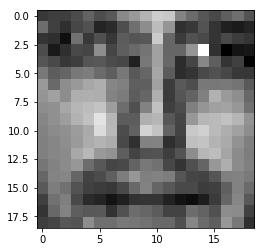

In [7]:
image = ffe.read_pgm("data/faces/train/face/face00004.pgm", byteorder='<')
plt.imshow(image, plt.cm.gray)
plt.show()

# NMF of image dataset

In [8]:
NMF_system = ffe.get_NMF_model(image_X_df)
# W
NMF_system.W

# H 
NMF_system.H;

In [9]:
# choose the j-th face 0 <= j <= 2427
j = 2427
im_orig = ffe.get_and_plot_image(image_X_df,j,False)
im_recon = ffe.get_and_plot_image(ffe.get_reconstructed_image(NMF_system.W,NMF_system.H,j),j,False)

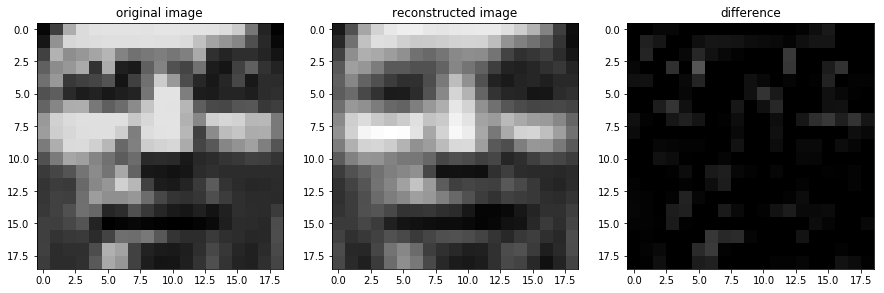

In [10]:
ffe.plot_orig_recon_diff(im_orig, im_recon)    

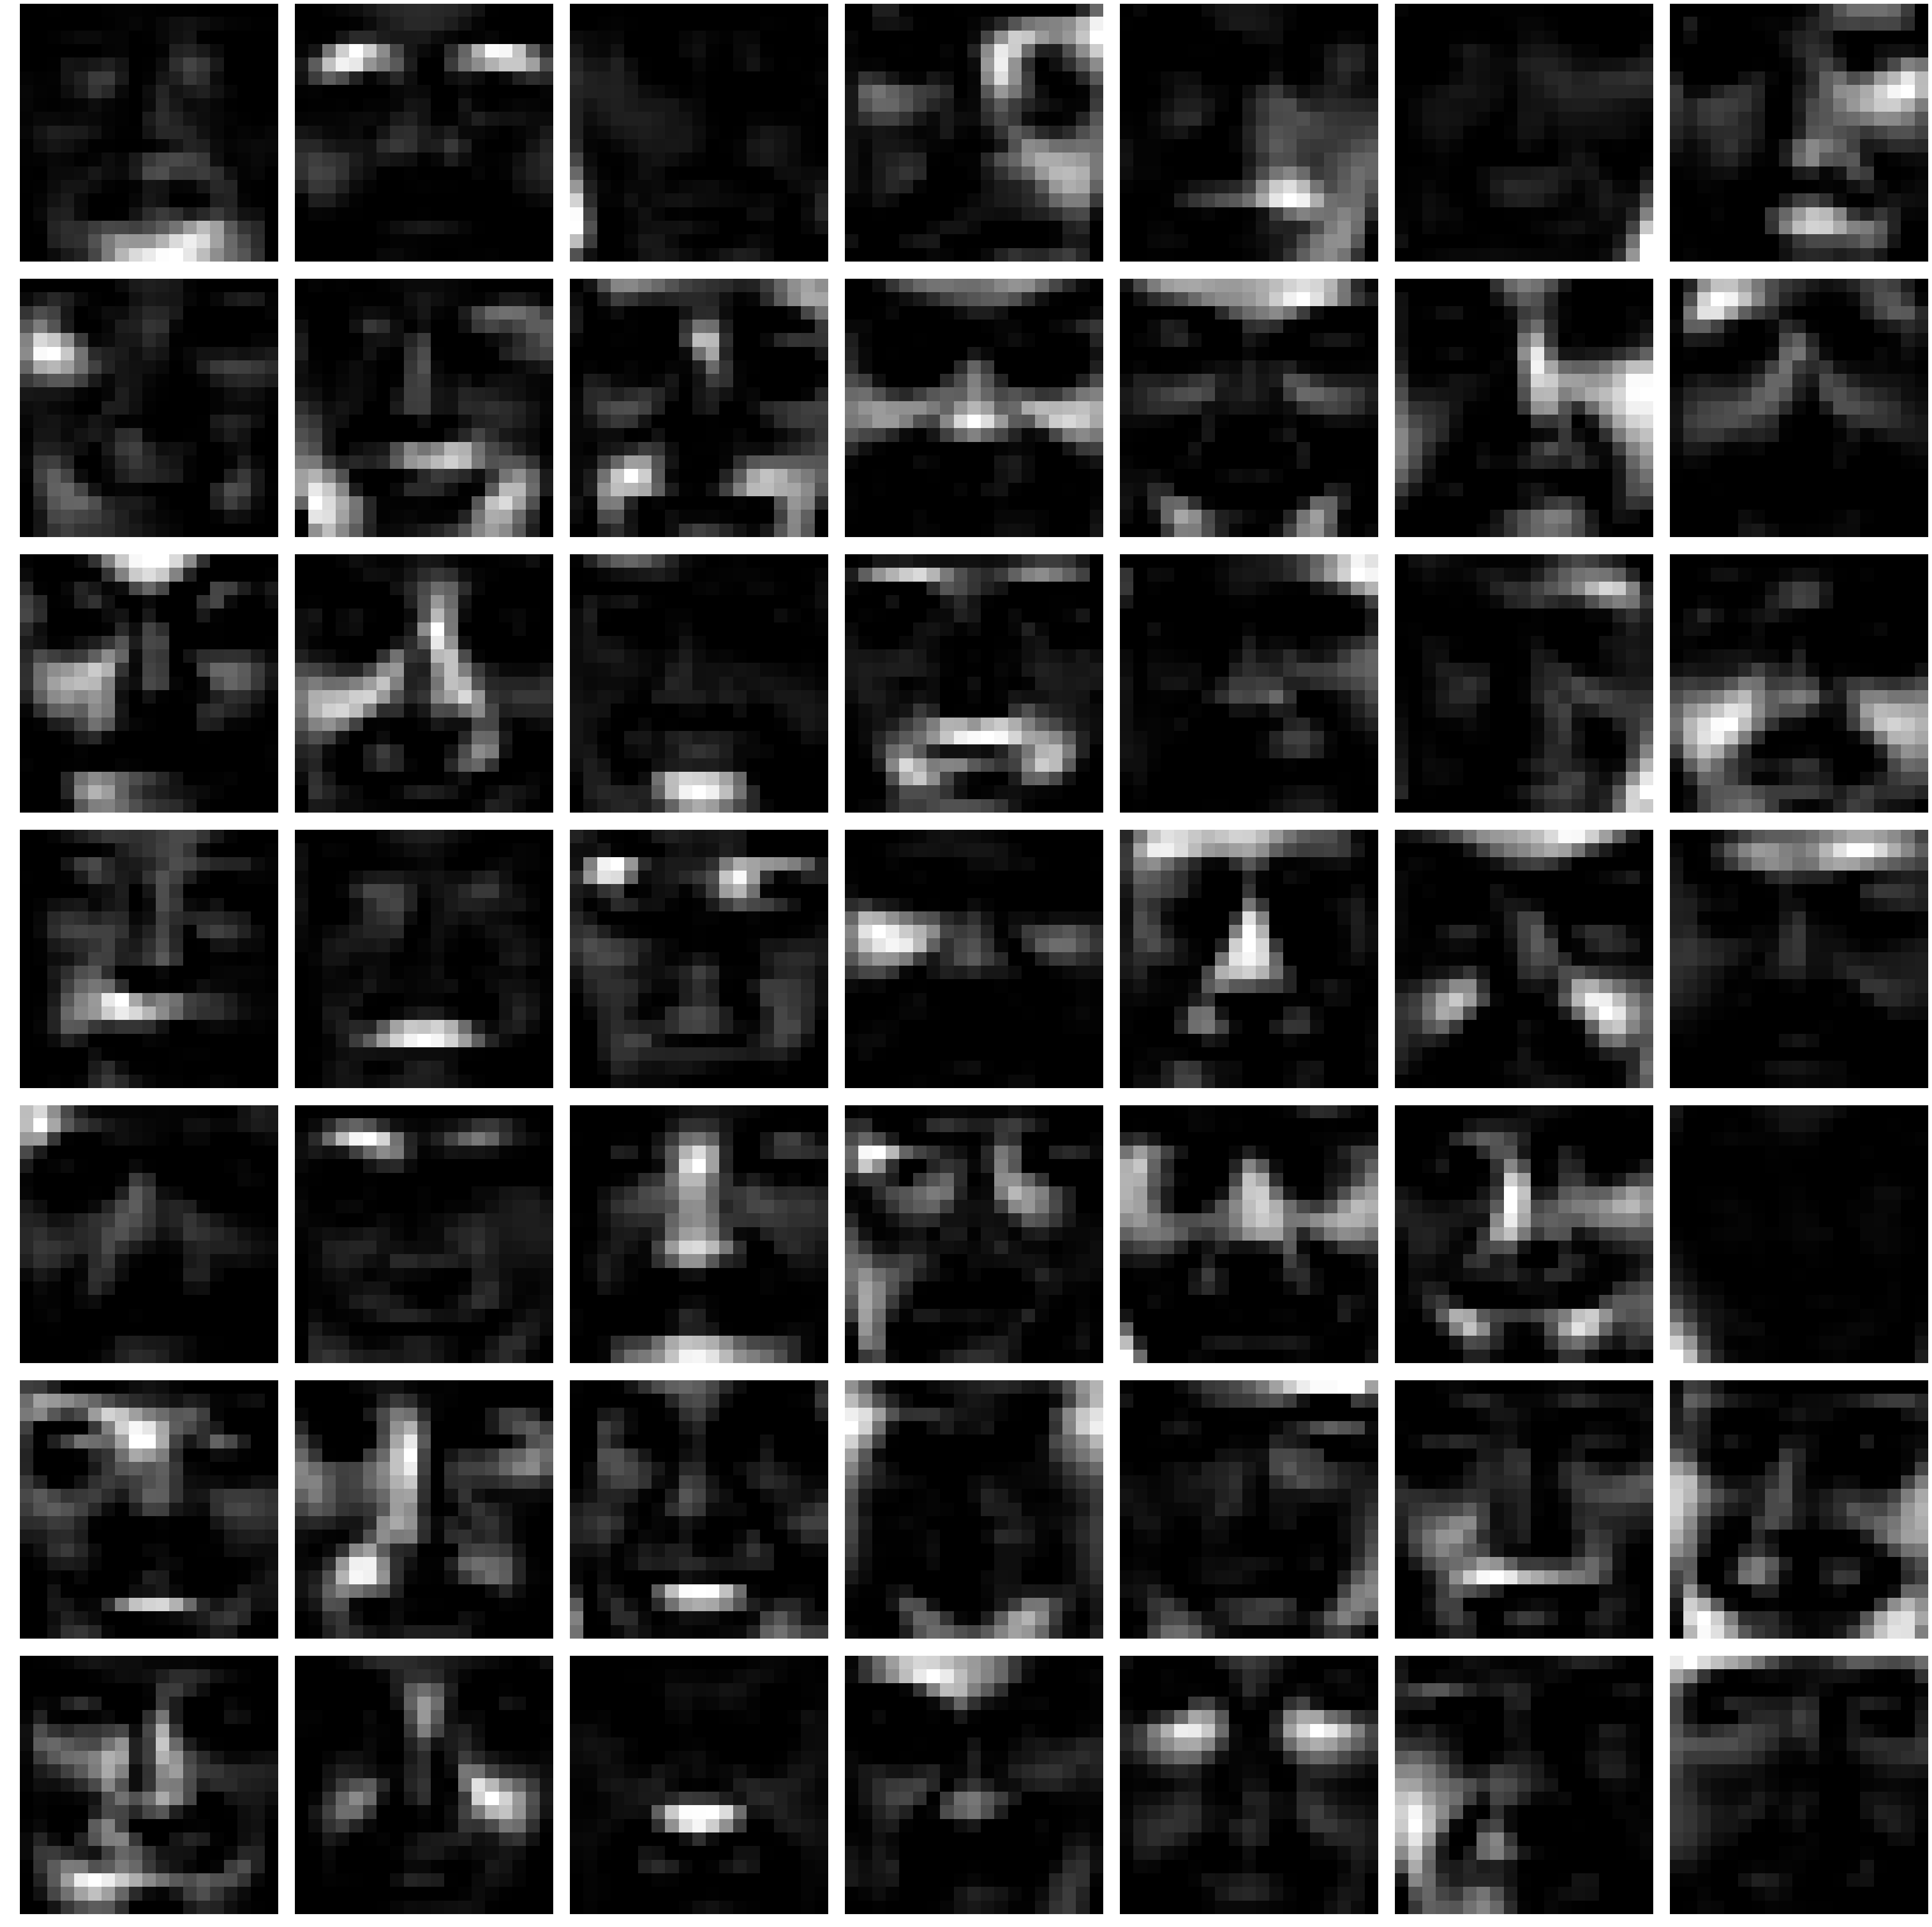

In [11]:
# The images bleow are interpreted as the "basis elements" of the human face
ffe.plot_facial_building_blocks(NMF_system.W)

---
## Text Analysis and Sparsity

I found a [blogging dataset](http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm) created in 2004 that I believe is usually used to assign authership attribution. Let's see what NMF does with it.

To find $r$ I will use an SVD decomposition to determine the number of features.

On the text if it is not done I will
1. Remove punctuation,
2. Apply a stemming algorithm,
3. Remove common words such as "and", "or", etc. 

In [13]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")

try:
    stop_words = stopwords.words('english')
except LookupError:
    nltk.download("stopwords")
    
def get_blogging_corpus(corpus_root_path):
    onlyfiles = [f for f in listdir(corpus_root_path) if isfile(join(corpus_root_path, f))]
    return onlyfiles
    
def clean_text(text):
    
    # split into words
    tokens = word_tokenize(text)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    
    # apply stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokens]
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryan.croke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
file_location = "data/conference_papers/NIPS_1987-2015.csv"
conference_papers_df = pd.read_csv(file_location)

In [20]:
conference_papers_df.head()

,Unnamed: 0,1987_1,1987_2,1987_3,1987_4,1987_5,1987_6,1987_7,1987_8,1987_9,...,2015_394,2015_395,2015_396,2015_397,2015_398,2015_399,2015_400,2015_401,2015_402,2015_403
0,abalone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abbeel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abbott,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abbreviate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,abbreviated,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
conference_papers_df.head().isnull().sum().sum()

0

In [78]:
text_model = NMF(n_components=110, 
                 init='random',
                 random_state=5,
                 solver='mu',
                 max_iter=1000) # n_components is r in literature
W = text_model.fit_transform(conference_papers_df.drop(['Unnamed: 0'],axis=1))
H = text_model.components_

In [79]:
j = 21
recon_temp = [0]*W.shape[0]
for count in range(W.shape[1]):
    recon_temp += W[:,count] * H[count,j]
    
# scale? 
for count in range(W.shape[1]):
    W_new = W*H.max()
    H_new = H/H.max()
    recon_temp += W_new[:,count] * H_new[count,j]

In [80]:
recon_temp

array([0.00390445, 0.0136699 , 0.08233196, ..., 0.00967765, 0.01000121,
       0.04855729])

In [81]:
original = conference_papers_df.iloc[:,j]

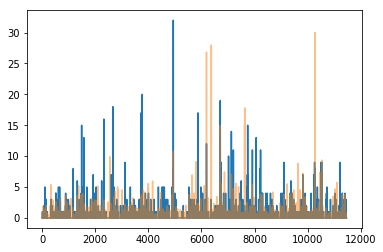

In [82]:
#(original - recon_temp).plot()
original.plot()
pd.Series(recon_temp).plot(alpha=0.5)

In [83]:
u, s, vh = np.linalg.svd(np.array(conference_papers_df.drop(['Unnamed: 0'],axis=1)))

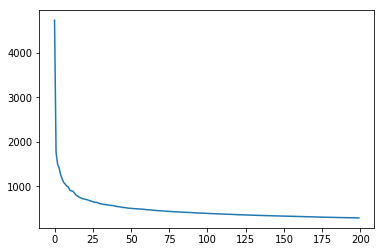

In [84]:
# plot singular values to try and find r
plt.plot(s[:200])

In [85]:
np.sort(recon_temp)

array([4.90102318e-17, 3.50657672e-15, 1.91746696e-14, ...,
       2.68331293e+01, 2.79650400e+01, 3.00200772e+01])

In [86]:
# filter H
H_col = H[:,1]
delta = 0.1
threshold = (1 - delta) * H_col.max()

In [87]:
H_col[H_col <= delta] = 0
H_col/H_col.sum())

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11038313, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.36538448, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10690243,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18412655, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10493969, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.21110549, 0.        , 0.18294208, 0.12011492, 0.     

In [90]:
(H_col/H_col.sum()).sum()

1.0